<a href="https://colab.research.google.com/github/mmassonn/Pneumonia_classification_XRay/blob/main/pneumonia_classification_Xception_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from keras.utils import np_utils

In [3]:
#Connect drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Load the training dataset

In [4]:
def loading_data(pathway):
  
  X_data=[]
  y_data=[]

  data_dir = pathway
  categories = ['NORMAL', 'PNEUMONIA']

  for i in categories:
      path = os.path.join(data_dir,i)
      for j in os.listdir(path):
          img = cv2.imread(os.path.join(path,j))

          X_data.append(img)
          y_data.append(i)
  
  return X_data, y_data

In [5]:
X_train, y_train = loading_data('drive/MyDrive/Projet_2022/pneumonia_classification_XRay/chest_xray/train')

In [6]:
len(y_train)

5232

In [7]:
from collections import Counter

In [8]:
Counter(y_train)

Counter({'NORMAL': 1349, 'PNEUMONIA': 3883})

In [9]:
X_type_tot = []
for img in X_train:
  NoneType = type(None)
  X_type = img.dtype
  X_type_tot.append(X_type)

In [10]:
Counter(X_type_tot)

Counter({dtype('uint8'): 5232})

In [ ]:
X_train[0].shape

(1200, 1296)

**Image normal vs pneumonia**

Text(0.5, 1.0, 'Pneumonia')

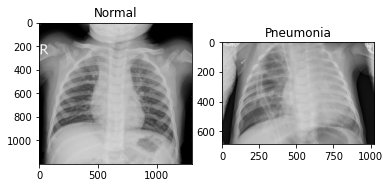

In [11]:
fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(X_train[0])
ax.set_title('Normal')

ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(X_train[2500])
ax.set_title('Pneumonia')

##Data preparation

In [12]:
def resize_img(X_train):
  
  X_train_new=[]
  
  for img in X_train:
    img = cv2.resize(img,(256,256))
    X_train_new.append(img)
  
  X_train = X_train_new
  
  return X_train

In [13]:
def array_img(X_train):

  X_train=np.array(X_train)

  return X_train

In [14]:
def reshape_img(X_train):

  X_train = X_train.reshape(-1, 256, 256, 3)
  
  return X_train

In [15]:
X_train = resize_img(X_train)
X_train = array_img(X_train)
X_train = reshape_img(X_train)

Text(0.5, 1.0, 'Normal')

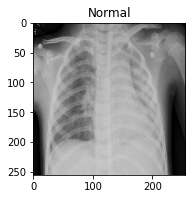

In [20]:
fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(X_train[2101])
ax.set_title('Normal')

##Split training dataset and validation dataset

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)   

In [22]:
def convert_data(data):

  new_data = []
  categories = ['NORMAL', 'PNEUMONIA']

  for i in data:
      new_data.append(categories.index(i))

  data = tf.keras.utils.to_categorical(new_data)

  return data

In [23]:
y_train = convert_data(y_train)
y_val = convert_data(y_val)

##Data augmentation

In [26]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

##Model Architecture

###base model with pre-trained weights

In [27]:
base_model = keras.applications.Xception( weights='imagenet', input_shape=(256, 256, 3), include_top=False)

83697664/83683744 [==============================] - 0s 0us/step


###freeze the base model

In [28]:
base_model.trainable = False

###Create a new model on top

In [33]:
inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)

scale_layer = layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) 

outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

##Configuring the model for training

In [35]:
model.compile(loss="categorical_crossentropy",
              optimizer= 'adam',
              metrics=["accuracy"])

##Fit the model

In [36]:
model.fit( X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
131/131 [==============================] - 90s 666ms/step - loss: 0.3159 - accuracy: 0.8669 - val_loss: 0.2656 - val_accuracy: 0.8844
Epoch 2/20
131/131 [==============================] - 87s 665ms/step - loss: 0.1961 - accuracy: 0.9202 - val_loss: 0.2114 - val_accuracy: 0.9045
Epoch 3/20
131/131 [==============================] - 88s 673ms/step - loss: 0.1781 - accuracy: 0.9278 - val_loss: 0.1992 - val_accuracy: 0.9093
Epoch 4/20
131/131 [==============================] - 87s 668ms/step - loss: 0.1741 - accuracy: 0.9321 - val_loss: 0.1711 - val_accuracy: 0.9265
Epoch 5/20
131/131 [==============================] - 86s 660ms/step - loss: 0.1644 - accuracy: 0.9338 - val_loss: 0.2248 - val_accuracy: 0.9026
Epoch 6/20
131/131 [==============================] - 88s 674ms/step - loss: 0.1609 - accuracy: 0.9393 - val_loss: 0.1925 - val_accuracy: 0.9102
Epoch 7/20
131/131 [==============================] - 90s 691ms/step - loss: 0.1541 - accuracy: 0.9388 - val_loss: 0.2078 - val_ac

##Do a round of fine-tuning of the entire model

In [37]:
base_model.trainable = True

In [38]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

In [39]:
model.compile(loss="categorical_crossentropy",
              optimizer= keras.optimizers.Adam(1e-5),
              metrics=["accuracy"])

In [40]:
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="convnet_from_scratch.keras", save_best_only=True, monitor="val_loss")]

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/10
131/131 [==============================] - 417s 3s/step - loss: 0.1262 - accuracy: 0.9477 - val_loss: 0.2112 - val_accuracy: 0.9255
Epoch 2/10
131/131 [==============================] - 427s 3s/step - loss: 0.0916 - accuracy: 0.9642 - val_loss: 0.1490 - val_accuracy: 0.9398
Epoch 3/10
131/131 [==============================] - 422s 3s/step - loss: 0.0842 - accuracy: 0.9692 - val_loss: 0.1308 - val_accuracy: 0.9494
Epoch 4/10
131/131 [==============================] - 418s 3s/step - loss: 0.0640 - accuracy: 0.9768 - val_loss: 0.0996 - val_accuracy: 0.9580
Epoch 5/10
131/131 [==============================] - 422s 3s/step - loss: 0.0625 - accuracy: 0.9744 - val_loss: 0.1299 - val_accuracy: 0.9513
Epoch 6/10
131/131 [==============================] - 414s 3s/step - loss: 0.0515 - accuracy: 0.9809 - val_loss: 0.1062 - val_accuracy: 0.9608
Epoch 7/10
131/131 [==============================] - 410s 3s/step - loss: 0.0460 - accuracy: 0.9826 - val_loss: 0.0859 - val_accuracy: 0.9666

##Displaying curves of loss and accuracy


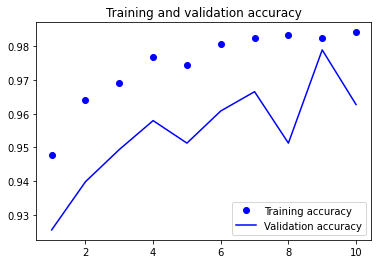

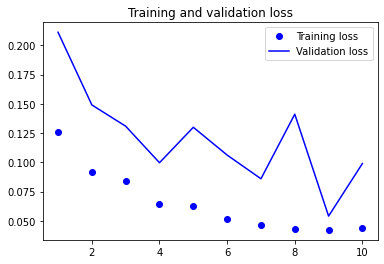

In [41]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

##Evaluating the model on the test set

In [45]:
X_test, y_test = loading_data('drive/MyDrive/Projet_2022/pneumonia_classification_XRay/chest_xray/test')

In [46]:
X_test

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8), array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [5, 5, 5],
         [4, 4, 4],
         [3, 3, 3]],
 
        [[0, 0

In [47]:
X_test = resize_img(X_test)
X_test = array_img(X_test)
X_test = reshape_img(X_test)
y_test = convert_data(y_test)

In [48]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(X_test, y_test)
test_acc = test_acc * 100
print(f"Test accuracy: {test_acc} %")

20/20 [==============================] - 11s 523ms/step - loss: 0.2424 - accuracy: 0.9183
Test accuracy: 91.82692170143127 %


In [49]:
model.save('Pn_model.h5')